In [5]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving archive.zip to archive.zip
User uploaded file "archive.zip" with length 63252113 bytes


In [6]:
from zipfile import ZipFile
file_name = "archive.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print("Done")

Done


In [23]:
import numpy as np
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D
from keras.optimizers import Adam
from keras.layers import MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator

In [8]:
train_dir = 'train'
val_dir = 'test'
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(48,48),
        batch_size=64,
        color_mode="grayscale",
        class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=(48,48),
        batch_size=64,
        color_mode="grayscale",
        class_mode='categorical')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [9]:
emotion_model = Sequential()
emotion_model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48,48,1)))
emotion_model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
emotion_model.add(MaxPooling2D(pool_size=(2, 2)))
emotion_model.add(Dropout(0.25))
emotion_model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
emotion_model.add(MaxPooling2D(pool_size=(2, 2)))
emotion_model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
emotion_model.add(MaxPooling2D(pool_size=(2, 2)))
emotion_model.add(Dropout(0.25))
emotion_model.add(Flatten())
emotion_model.add(Dense(1024, activation='relu'))
emotion_model.add(Dropout(0.5))
emotion_model.add(Dense(7, activation='softmax'))

In [27]:
from tensorflow.keras.optimizers import Adam

# Update the optimizer configuration
emotion_model.compile(loss='categorical_crossentropy',
                      optimizer=Adam(learning_rate=0.0001),
                      metrics=['accuracy'])

# Continue with the model training
emotion_model_info = emotion_model.fit_generator(
    train_generator,
    steps_per_epoch=28709 // 64,
    epochs=100,
    # Other parameters...
 validation_data=validation_generator,
        validation_steps=7178 // 64
)


Epoch 1/100


<ipython-input-27-5688765f2fc0>:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  emotion_model_info = emotion_model.fit_generator(


448/448 [==============================] - 17s 32ms/step - loss: 0.3539 - accuracy: 0.8726 - val_loss: 1.2321 - val_accuracy: 0.6244
Epoch 2/100
448/448 [==============================] - 15s 33ms/step - loss: 0.3431 - accuracy: 0.8761 - val_loss: 1.2134 - val_accuracy: 0.6249
Epoch 3/100
448/448 [==============================] - 14s 31ms/step - loss: 0.3335 - accuracy: 0.8797 - val_loss: 1.2349 - val_accuracy: 0.6275
Epoch 4/100
448/448 [==============================] - 14s 32ms/step - loss: 0.3180 - accuracy: 0.8862 - val_loss: 1.2270 - val_accuracy: 0.6283
Epoch 5/100
448/448 [==============================] - 14s 31ms/step - loss: 0.3112 - accuracy: 0.8896 - val_loss: 1.2651 - val_accuracy: 0.6272
Epoch 6/100
448/448 [==============================] - 15s 32ms/step - loss: 0.3088 - accuracy: 0.8911 - val_loss: 1.2639 - val_accuracy: 0.6240
Epoch 7/100
448/448 [==============================] - 14s 31ms/step - loss: 0.2972 - accuracy: 0.8926 - val_loss: 1.2499 - val_accuracy: 0.62

In [29]:
#Saving the model
emotion_model.save('model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [30]:
from keras.models import load_model
emotion_model = load_model('model.h5')

In [31]:
def emotion_analysis(emotions):
    objects = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
    y_pos = np.arange(len(objects))

    plt.bar(y_pos, emotions, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    plt.ylabel('percentage')
    plt.title('emotion')

    plt.show()

In [32]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [37]:
take_photo()

<IPython.core.display.Javascript object>

'photo.jpg'

OpenCV(4.8.0) /io/opencv/modules/objdetect/src/cascadedetect.cpp:1689: error: (-215:Assertion failed) !empty() in function 'detectMultiScale'

1/1 [==============================] - 0s 20ms/step


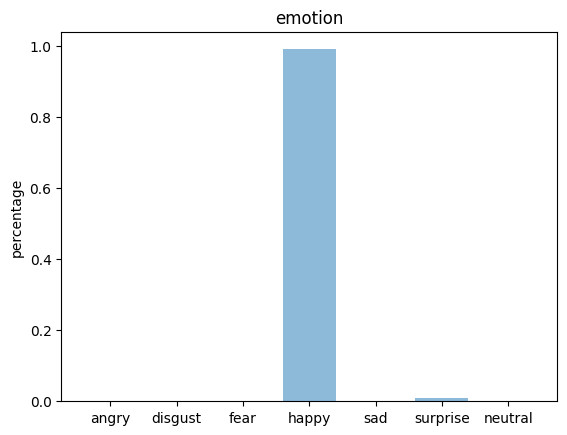

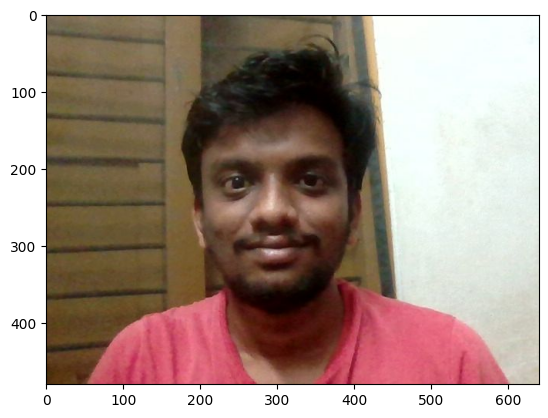

In [38]:
import cv2

def facecrop(image):
    facedata = '/content/haarcascade_frontalface_alt.xml'
    cascade = cv2.CascadeClassifier(facedata)

    img = cv2.imread(image)

    try:

        minisize = (img.shape[1],img.shape[0])
        miniframe = cv2.resize(img, minisize)

        faces = cascade.detectMultiScale(miniframe)

        for f in faces:
            x, y, w, h = [ v for v in f ]
            cv2.rectangle(img, (x,y), (x+w,y+h), (0,255,0), 2)

            sub_face = img[y:y+h, x:x+w]


            cv2.imwrite('capture.jpg', sub_face)
            #print ("Writing: " + image)

    except Exception as e:
        print (e)




if __name__ == '__main__':
    facecrop('/content/photo.jpg')

#Testing a file.

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

import numpy as np
import matplotlib.pyplot as plt


file = '/content/photo.jpg'
true_image = image.load_img(file)
img = image.load_img(file, color_mode="grayscale", target_size=(48, 48))

x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = emotion_model.predict(x)
emotion_analysis(custom[0])

x = np.array(x, 'float32')
x = x.reshape([48, 48]);


plt.imshow(true_image)
plt.show()